In [1]:
from fastai.vision.all import *
from fastai.vision.data import *
from fastai.vision.core import *
from fastai2_extensions.interpret.all import *
# from fastai.imports import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
path = Path('../resources/feb2021_abclass')

In [4]:
vis_path = Path('visualizations_02-02-2021/round2')
os.path.exists(vis_path)

True

In [5]:
os.listdir(path)

['.DS_Store',
 'models',
 'val',
 'fastai_resnet50.pkl',
 '.ipynb_checkpoints',
 'train',
 'test']

In [6]:
import warnings

In [7]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [8]:
data = ImageDataLoaders.from_folder(path, train='train', valid='val', 
                                  batch_tfms=[*aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.0, max_warp=0, p_affine=0),Normalize.from_stats(*imagenet_stats)],
                                  bs=32, 
                                  resize_method=ResizeMethod.Squish,
                                  size=(512, 512), num_workers=16) 

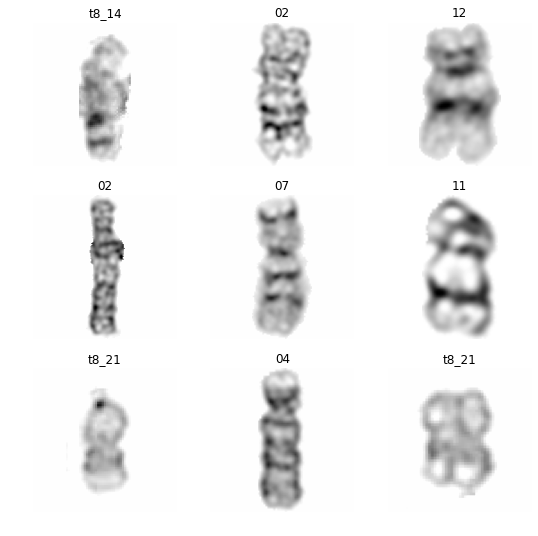

In [9]:
data.show_batch()

In [9]:
from fastai.metrics import error_rate, BalancedAccuracy, F1Score, RocAuc

In [10]:
f1_score = F1Score(average='weighted')
acc = BalancedAccuracy()

In [11]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

<h1><center style='background:orange'>ResNet34 Exp1</center></h1>

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, acc, f1_score])

In [12]:
defaults.device = torch.device('cuda')

In [13]:
learn.recorder.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 256 x 256 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,2.526627,1.919470,0.587248,0.433476,0.389137,01:33
1,1.383462,1.067645,0.322148,0.683761,0.675149,01:31
2,1.007138,0.926915,0.271812,0.729915,0.726798,01:31


SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=7.585775847473997e-07)

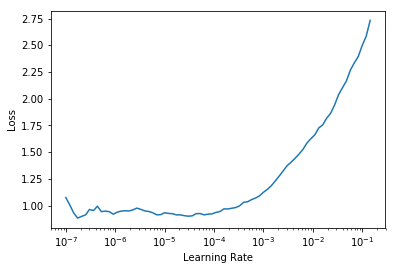

In [16]:
learn.unfreeze()
learn.lr_find()

In [17]:
learn.fit_one_cycle(5, slice(8e-5, 8e-4))

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,0.977876,0.984344,0.291946,0.683476,0.691109,01:56
1,0.522825,0.408575,0.107383,0.878775,0.892209,01:55
2,0.311282,0.272400,0.087248,0.890313,0.911582,01:55
3,0.122387,0.153329,0.050336,0.945869,0.949526,01:55
4,0.064280,0.122634,0.040268,0.957692,0.959774,01:55


In [18]:
learn.save('resnet34_exp1_shortcycle_bs32_is512.h5')

Path('feb2021_abclass/models/resnet34_exp1_shortcycle_bs32_is512.h5.pth')

## Interp - val data

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

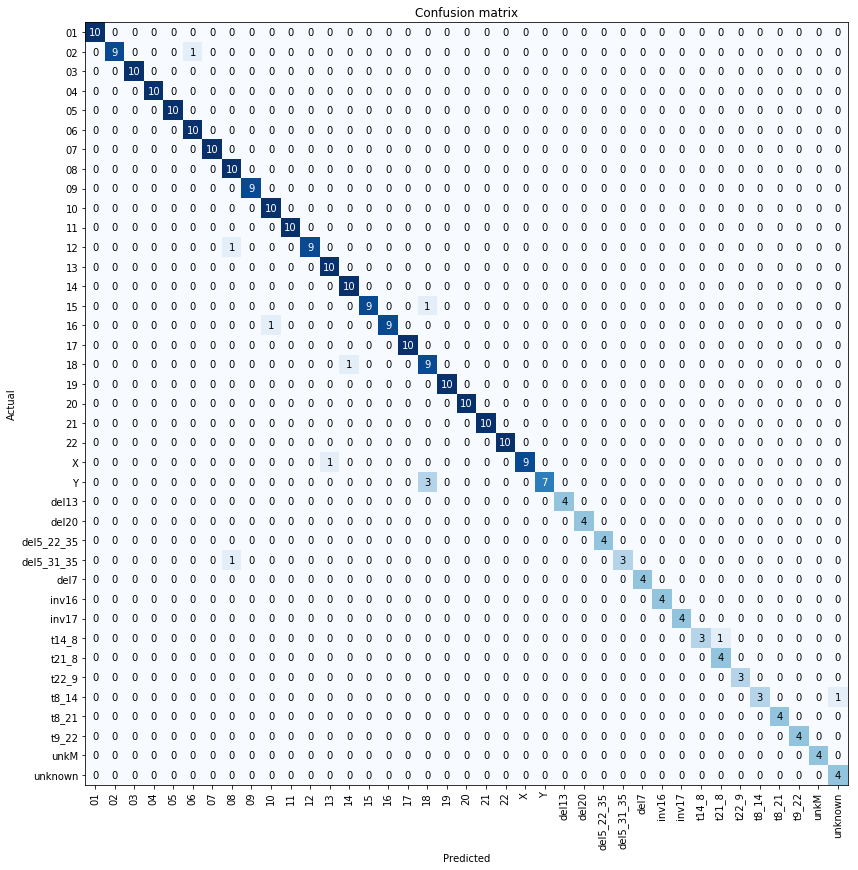

In [22]:
interp.plot_confusion_matrix(figsize=(12,12))

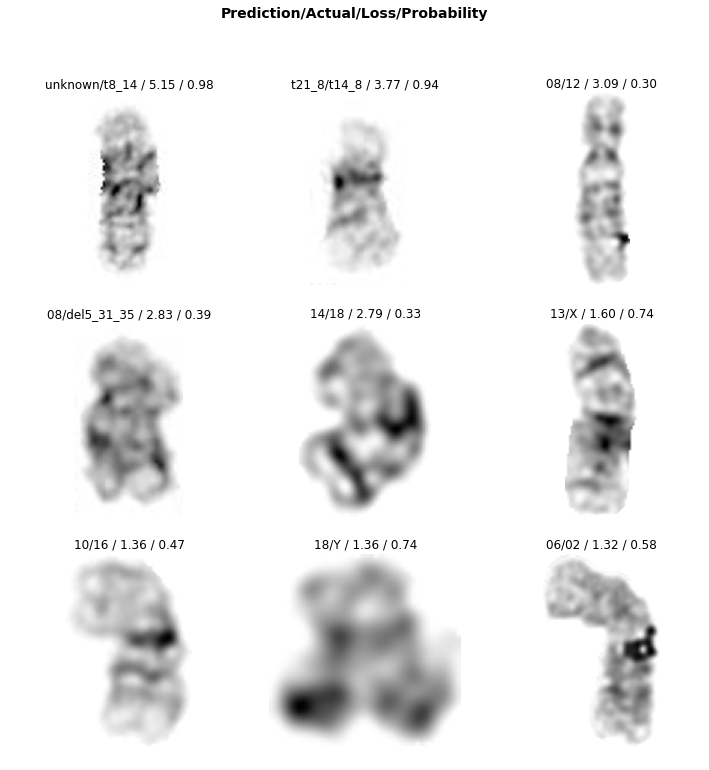

In [25]:
interp.plot_top_losses(9, figsize=(12,12))

In [27]:
interp.print_classification_report()

              precision    recall  f1-score   support

          01       1.00      1.00      1.00        10
          02       1.00      0.90      0.95        10
          03       1.00      1.00      1.00        10
          04       1.00      1.00      1.00        10
          05       1.00      1.00      1.00        10
          06       0.91      1.00      0.95        10
          07       1.00      1.00      1.00        10
          08       0.83      1.00      0.91        10
          09       1.00      1.00      1.00         9
          10       0.91      1.00      0.95        10
          11       1.00      1.00      1.00        10
          12       1.00      0.90      0.95        10
          13       0.91      1.00      0.95        10
          14       0.91      1.00      0.95        10
          15       1.00      0.90      0.95        10
          16       1.00      0.90      0.95        10
          17       1.00      1.00      1.00        10
          18       0.69    

## Test data

In [28]:
data = ImageDataLoaders.from_folder(path, train='train', valid='test', 
                                  batch_tfms=[*aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.0, max_warp=0, p_affine=0),Normalize.from_stats(*imagenet_stats)],
                                  bs=32, 
                                  resize_method=ResizeMethod.Squish,
                                  size=(512, 512), num_workers=16) 

In [29]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, acc, f1_score])

In [30]:
learn.load('resnet34_exp1_shortcycle_bs32_is512.h5')

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

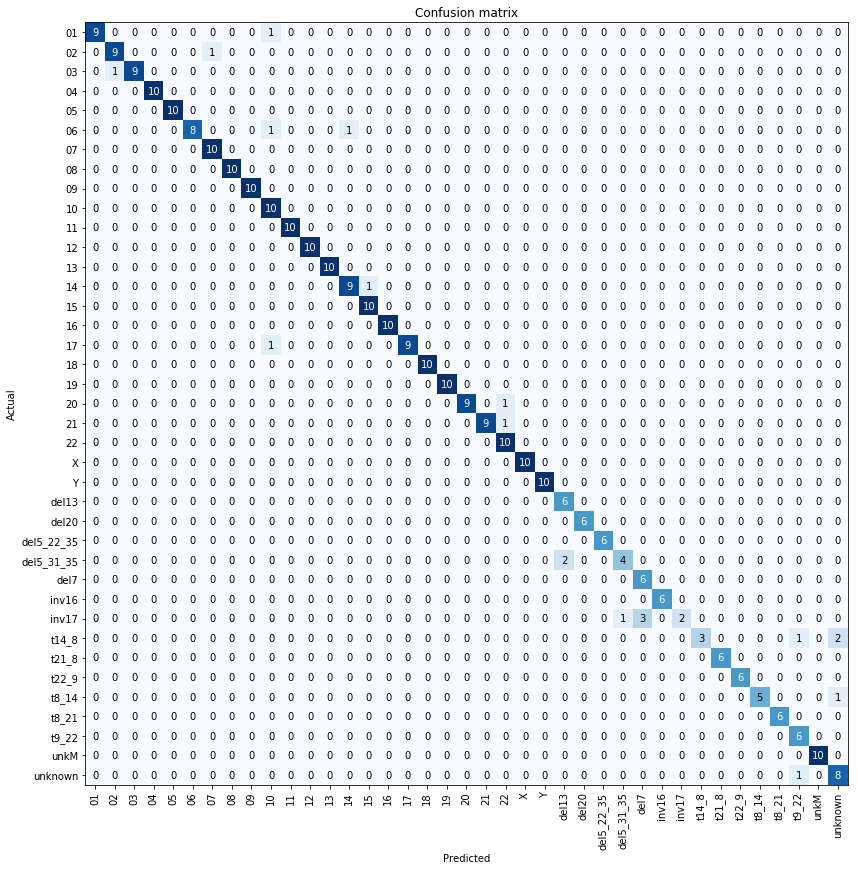

In [32]:
conf_matrix = interp.plot_confusion_matrix(figsize=(12,12))

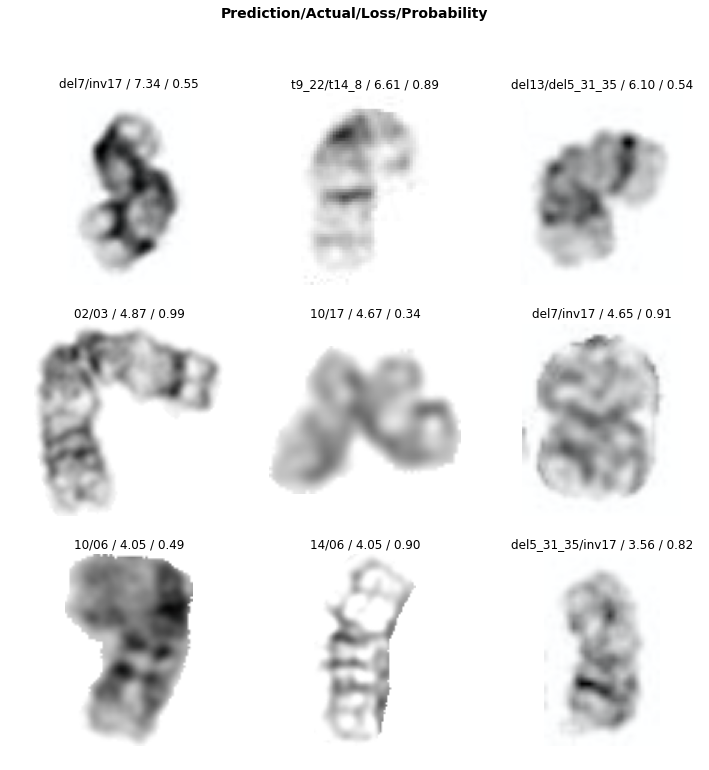

In [33]:
top_losses = interp.plot_top_losses(9, figsize=(12,12))

In [34]:
interp.print_classification_report()

              precision    recall  f1-score   support

          01       1.00      0.90      0.95        10
          02       0.90      0.90      0.90        10
          03       1.00      0.90      0.95        10
          04       1.00      1.00      1.00        10
          05       1.00      1.00      1.00        10
          06       1.00      0.80      0.89        10
          07       0.91      1.00      0.95        10
          08       1.00      1.00      1.00        10
          09       1.00      1.00      1.00        10
          10       0.77      1.00      0.87        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       0.90      0.90      0.90        10
          15       0.91      1.00      0.95        10
          16       1.00      1.00      1.00        10
          17       1.00      0.90      0.95        10
          18       1.00    

In [35]:
y = interp.targs
p = interp.decoded

In [38]:
from sklearn.metrics import f1_score as f1
print(f"weighted f1: {f1(y, p, average = 'weighted')}")
print(f"macro avg f1: {f1(y, p, average = 'macro')}")
print(f"micro avg f1: {f1(y, p, average = 'micro')}")

weighted f1: 0.9382652414179754
macro avg f1: 0.928883719043902
micro avg f1: 0.9406528189910978


In [39]:
from sklearn.metrics import balanced_accuracy_score as bal_acc
print(f"balanced acc: {bal_acc(y, p)}")

balanced acc: 0.9313390313390314


<h1><center style='background:orange'>ResNet34 Exp2</center></h1>

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, acc, f1_score])

In [12]:
defaults.device = torch.device('cuda')

In [13]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,2.510189,1.653334,0.503356,0.513105,0.476852,01:33
1,1.411556,1.164956,0.359060,0.650427,0.635408,01:31
2,0.970216,0.966690,0.305369,0.693875,0.695594,01:31


SuggestedLRs(lr_min=5.754399353463669e-07, lr_steep=6.309573450380412e-07)

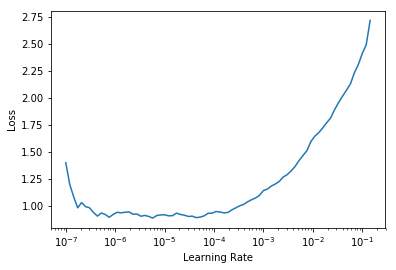

In [14]:
learn.unfreeze()
learn.lr_find()

In [15]:
learn.fit_one_cycle(5, slice(9e-5, 9e-4))

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,0.967636,0.959910,0.261745,0.722222,0.731624,01:56
1,0.553127,0.507664,0.151007,0.837607,0.842890,01:56
2,0.277380,0.240598,0.080537,0.907407,0.917573,01:56
3,0.129073,0.134442,0.036913,0.956125,0.963213,01:56
4,0.064285,0.120002,0.043624,0.947151,0.956121,01:56


In [16]:
learn.save('resnet34_exp2_shortcycle_bs32_is512.h5')

Path('feb2021_abclass/models/resnet34_exp2_shortcycle_bs32_is512.h5.pth')

## Interp - val data

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

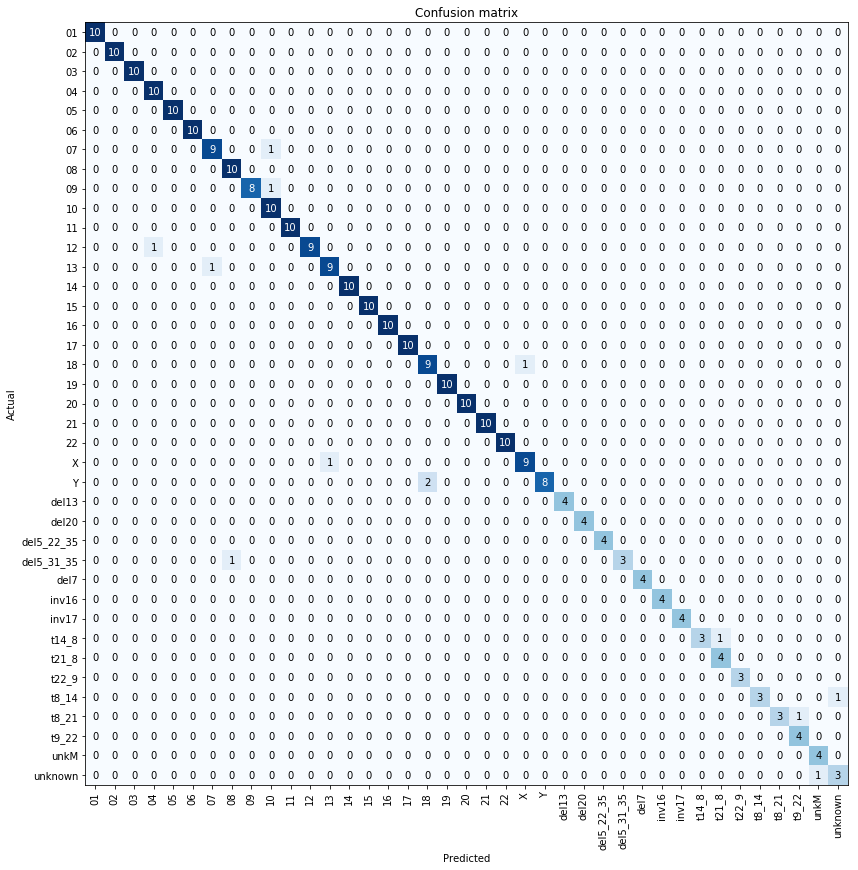

In [18]:
interp.plot_confusion_matrix(figsize=(12,12))

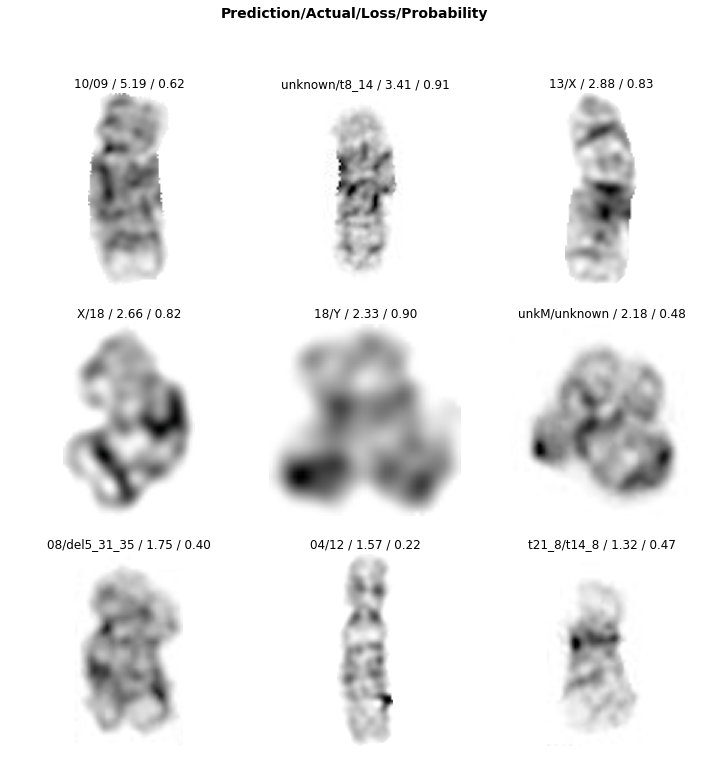

In [19]:
interp.plot_top_losses(9, figsize=(12,12))

In [20]:
interp.print_classification_report()

              precision    recall  f1-score   support

          01       1.00      1.00      1.00        10
          02       1.00      1.00      1.00        10
          03       1.00      1.00      1.00        10
          04       0.91      1.00      0.95        10
          05       1.00      1.00      1.00        10
          06       1.00      1.00      1.00        10
          07       0.90      0.90      0.90        10
          08       0.91      1.00      0.95        10
          09       1.00      0.89      0.94         9
          10       0.83      1.00      0.91        10
          11       1.00      1.00      1.00        10
          12       1.00      0.90      0.95        10
          13       0.90      0.90      0.90        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00      1.00      1.00        10
          18       0.82    

## Test data

In [21]:
data = ImageDataLoaders.from_folder(path, train='train', valid='test', 
                                  batch_tfms=[*aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.0, max_warp=0, p_affine=0),Normalize.from_stats(*imagenet_stats)],
                                  bs=32, 
                                  resize_method=ResizeMethod.Squish,
                                  size=(512, 512), num_workers=16) 

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, acc, f1_score])

In [23]:
learn.load('resnet34_exp2_shortcycle_bs32_is512.h5')

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

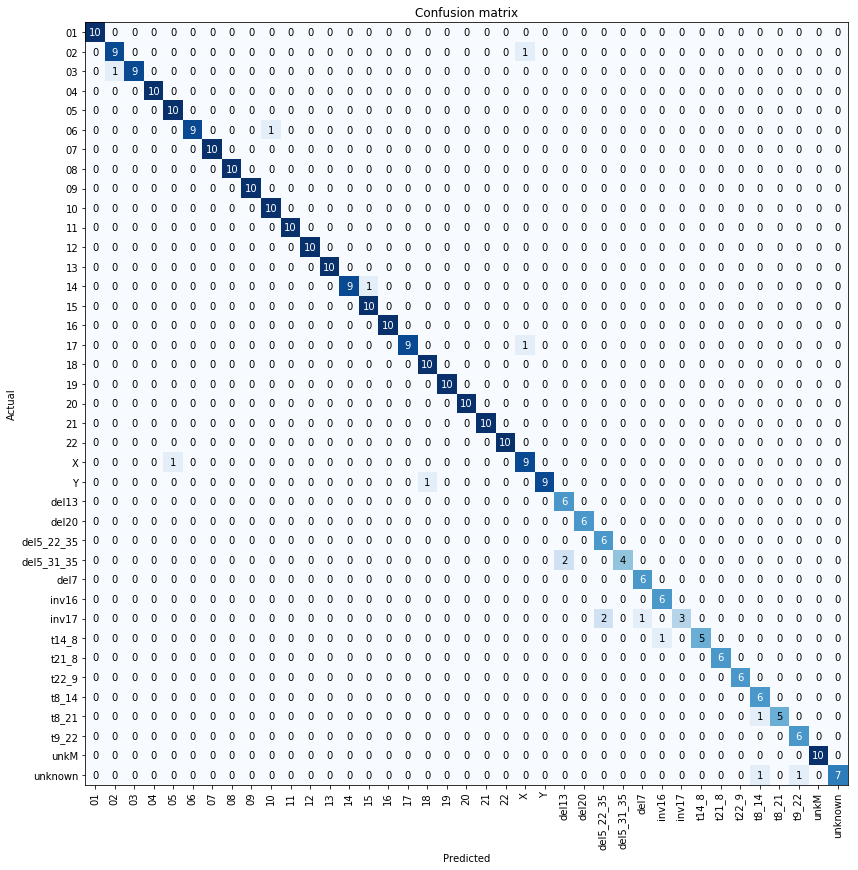

In [25]:
conf_matrix = interp.plot_confusion_matrix(figsize=(12,12))

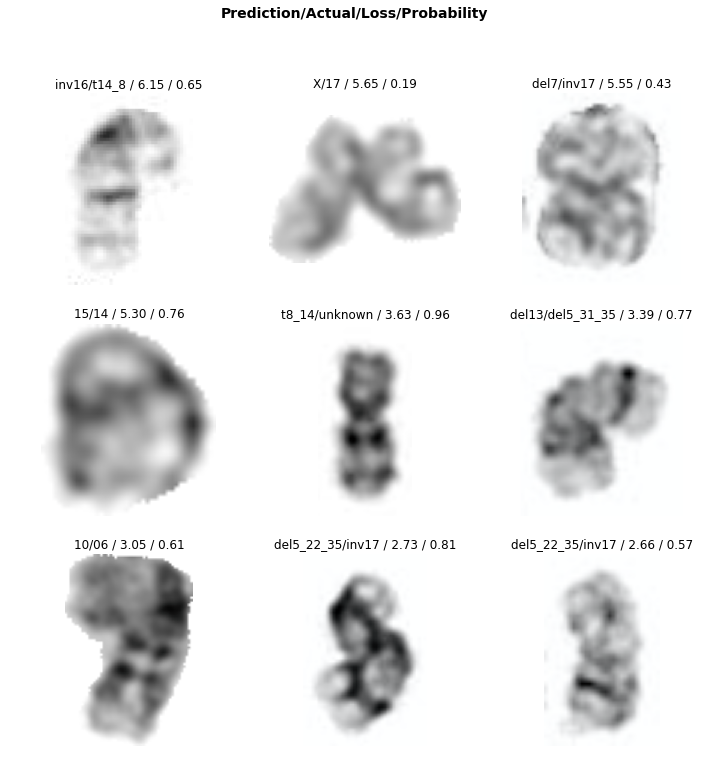

In [26]:
top_losses = interp.plot_top_losses(9, figsize=(12,12))

In [27]:
interp.print_classification_report()

              precision    recall  f1-score   support

          01       1.00      1.00      1.00        10
          02       0.90      0.90      0.90        10
          03       1.00      0.90      0.95        10
          04       1.00      1.00      1.00        10
          05       0.91      1.00      0.95        10
          06       1.00      0.90      0.95        10
          07       1.00      1.00      1.00        10
          08       1.00      1.00      1.00        10
          09       1.00      1.00      1.00        10
          10       0.91      1.00      0.95        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      0.90      0.95        10
          15       0.91      1.00      0.95        10
          16       1.00      1.00      1.00        10
          17       1.00      0.90      0.95        10
          18       0.91    

In [28]:
y = interp.targs
p = interp.decoded

In [29]:
from sklearn.metrics import f1_score as f1
print(f"weighted f1: {f1(y, p, average = 'weighted')}")
print(f"macro avg f1: {f1(y, p, average = 'macro')}")
print(f"micro avg f1: {f1(y, p, average = 'micro')}")

weighted f1: 0.9515226548140808
macro avg f1: 0.9436927332676317
micro avg f1: 0.9525222551928784


In [30]:
from sklearn.metrics import balanced_accuracy_score as bal_acc
print(f"balanced acc: {bal_acc(y, p)}")

balanced acc: 0.9464387464387465


<h1><center style='background:orange'>ResNet34 Exp3</center></h1>

In [31]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, acc, f1_score])

In [32]:
defaults.device = torch.device('cuda')

In [33]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,2.529816,1.600620,0.516320,0.493732,0.455198,01:32
1,1.420354,1.096400,0.344214,0.646439,0.653354,01:32
2,0.988768,1.136100,0.373887,0.618234,0.606456,01:32


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

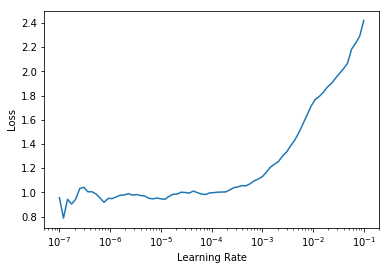

In [34]:
learn.unfreeze()
learn.lr_find()

In [35]:
learn.fit_one_cycle(5, slice(8e-5, 8e-4))

epoch,train_loss,valid_loss,error_rate,balanced_accuracy_score,f1_score,time
0,0.988361,1.259422,0.364985,0.625926,0.626386,01:56
1,0.539442,0.478274,0.163205,0.834188,0.829051,01:57
2,0.271517,0.287209,0.074184,0.918234,0.923240,01:57
3,0.124444,0.215538,0.068249,0.921937,0.929860,01:57
4,0.061506,0.209273,0.068249,0.923362,0.929399,01:57


In [36]:
learn.save('resnet34_exp3_shortcycle_bs32_is512.h5')

Path('feb2021_abclass/models/resnet34_exp3_shortcycle_bs32_is512.h5.pth')

## Interp - val data

In [37]:
interp = ClassificationInterpretation.from_learner(learn)

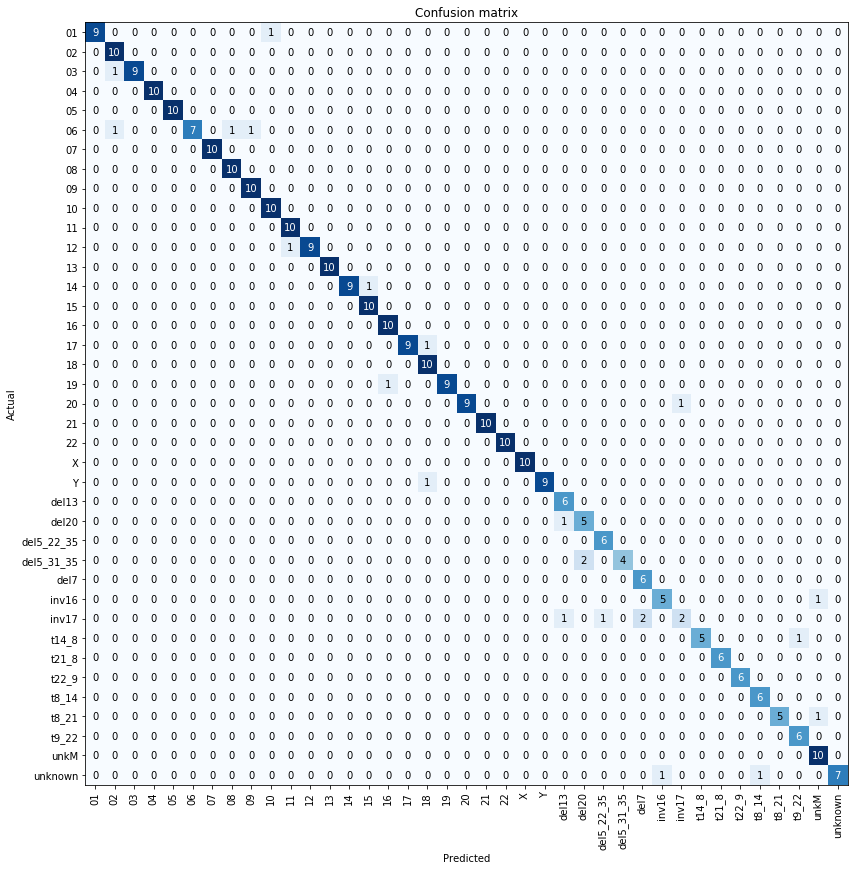

In [38]:
interp.plot_confusion_matrix(figsize=(12,12))

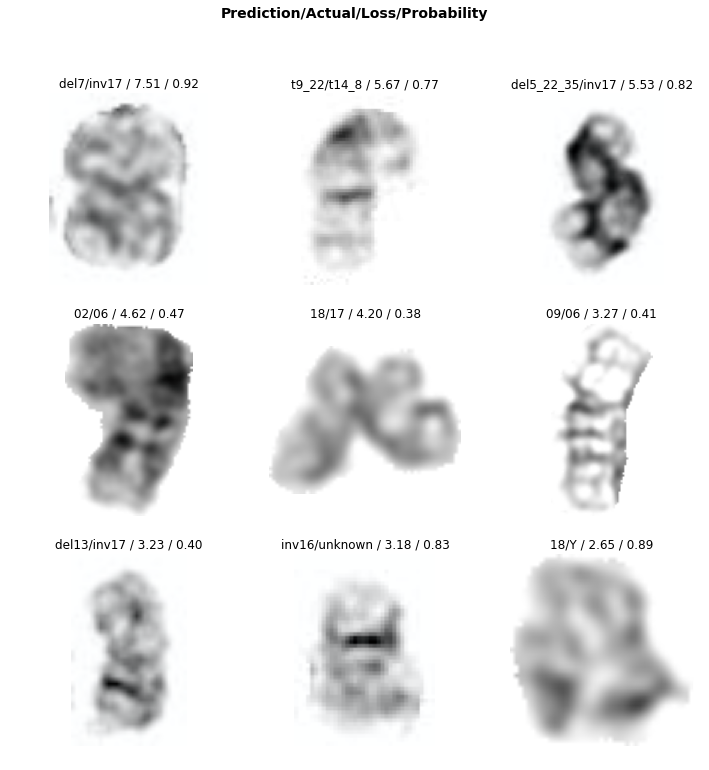

In [39]:
interp.plot_top_losses(9, figsize=(12,12))

In [40]:
interp.print_classification_report()

              precision    recall  f1-score   support

          01       1.00      0.90      0.95        10
          02       0.83      1.00      0.91        10
          03       1.00      0.90      0.95        10
          04       1.00      1.00      1.00        10
          05       1.00      1.00      1.00        10
          06       1.00      0.70      0.82        10
          07       1.00      1.00      1.00        10
          08       0.91      1.00      0.95        10
          09       0.91      1.00      0.95        10
          10       0.91      1.00      0.95        10
          11       0.91      1.00      0.95        10
          12       1.00      0.90      0.95        10
          13       1.00      1.00      1.00        10
          14       1.00      0.90      0.95        10
          15       0.91      1.00      0.95        10
          16       0.91      1.00      0.95        10
          17       1.00      0.90      0.95        10
          18       0.83    

## Test data

In [41]:
data = ImageDataLoaders.from_folder(path, train='train', valid='test', 
                                  batch_tfms=[*aug_transforms(flip_vert=False, max_lighting=0.1, max_zoom=1.0, max_warp=0, p_affine=0),Normalize.from_stats(*imagenet_stats)],
                                  bs=32, 
                                  resize_method=ResizeMethod.Squish,
                                  size=(512, 512), num_workers=16) 

In [42]:
learn = cnn_learner(data, models.resnet34, metrics=[error_rate, acc, f1_score])

In [43]:
learn.load('resnet34_exp1_shortcycle_bs32_is512.h5')

In [44]:
learn.load('resnet34_exp3_shortcycle_bs32_is512.h5')

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

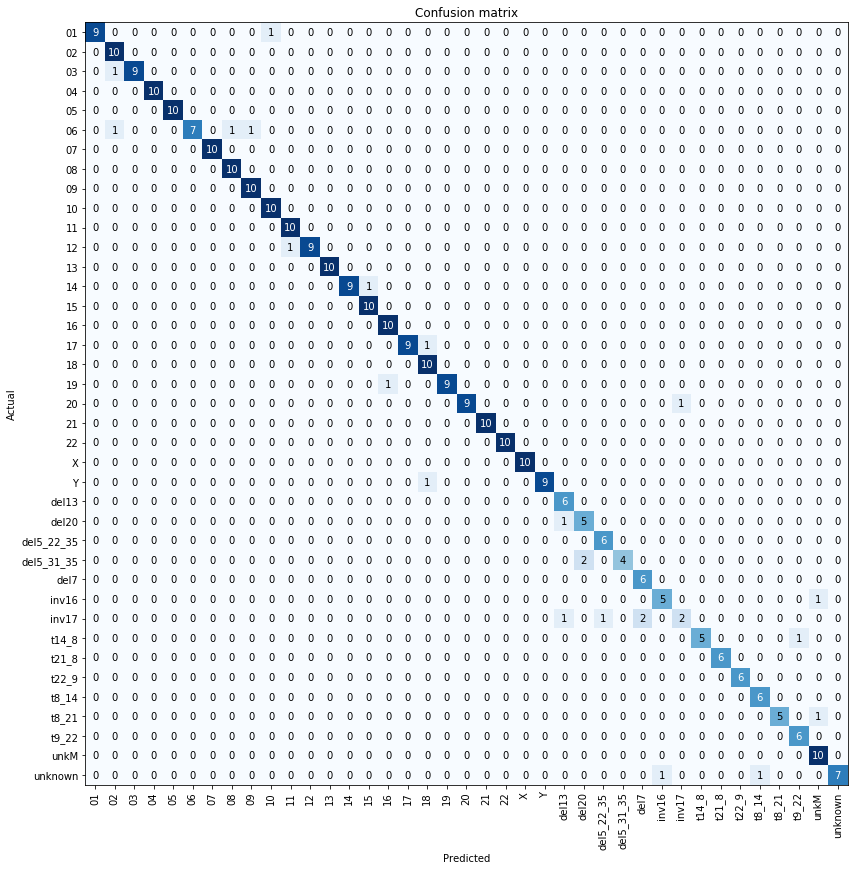

In [46]:
conf_matrix = interp.plot_confusion_matrix(figsize=(12,12))

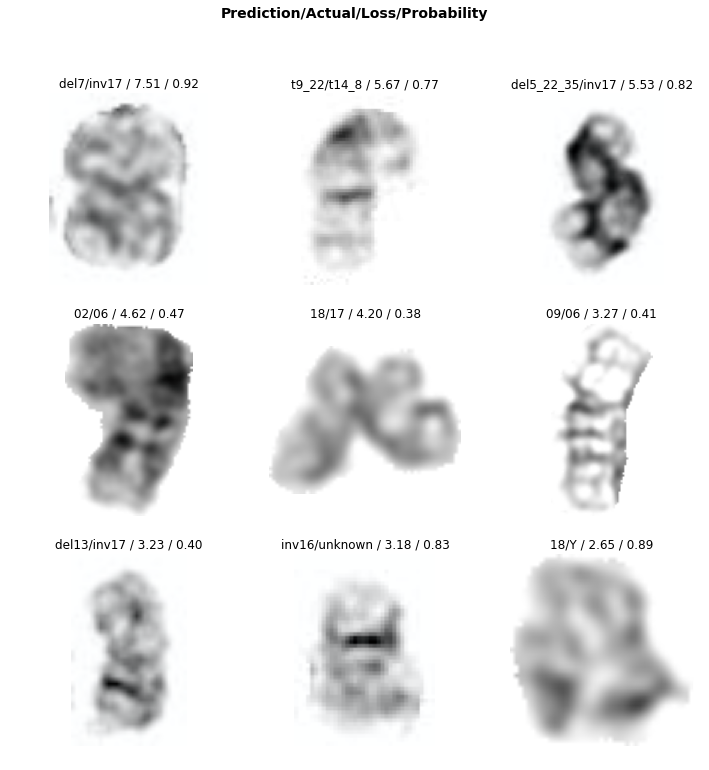

In [47]:
top_losses = interp.plot_top_losses(9, figsize=(12,12))

In [48]:
interp.print_classification_report()

              precision    recall  f1-score   support

          01       1.00      0.90      0.95        10
          02       0.83      1.00      0.91        10
          03       1.00      0.90      0.95        10
          04       1.00      1.00      1.00        10
          05       1.00      1.00      1.00        10
          06       1.00      0.70      0.82        10
          07       1.00      1.00      1.00        10
          08       0.91      1.00      0.95        10
          09       0.91      1.00      0.95        10
          10       0.91      1.00      0.95        10
          11       0.91      1.00      0.95        10
          12       1.00      0.90      0.95        10
          13       1.00      1.00      1.00        10
          14       1.00      0.90      0.95        10
          15       0.91      1.00      0.95        10
          16       0.91      1.00      0.95        10
          17       1.00      0.90      0.95        10
          18       0.83    

In [49]:
y = interp.targs
p = interp.decoded

In [50]:
from sklearn.metrics import f1_score as f1
print(f"weighted f1: {f1(y, p, average = 'weighted')}")
print(f"macro avg f1: {f1(y, p, average = 'macro')}")
print(f"micro avg f1: {f1(y, p, average = 'micro')}")

weighted f1: 0.9293993866756173
macro avg f1: 0.9196856941141291
micro avg f1: 0.9317507418397626


In [51]:
from sklearn.metrics import balanced_accuracy_score as bal_acc
print(f"balanced acc: {bal_acc(y, p)}")

balanced acc: 0.9233618233618234
